In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import lightgbm as lgb
from scipy.stats import zscore
import warnings

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [3]:
FILE_PATH = '/content/dataset_med.csv'
TARGET_COLUMN = 'survived'

In [4]:
try:
    data = pd.read_csv(FILE_PATH)
    print(f"Data loaded successfully. Shape: {data.shape}")
except FileNotFoundError:
    print(f"Error: File not found at '{FILE_PATH}'. Please upload your dataset.")
    data = None

Data loaded successfully. Shape: (180721, 17)



Target Distribution:
survived
0.0    140997
1.0     39723
Name: count, dtype: int64


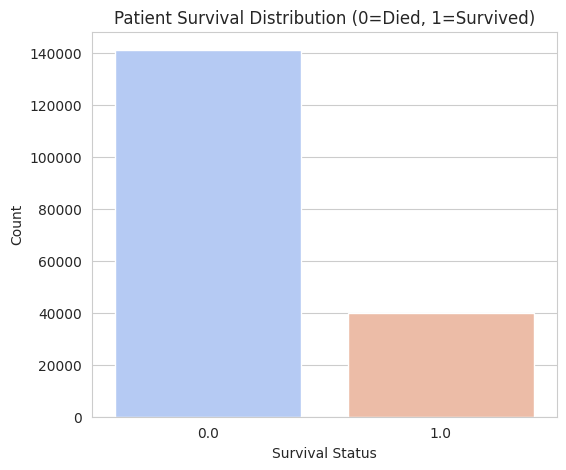

Note: The target variable is imbalanced. We must use robust metrics like AUC and Precision/Recall.


In [5]:
if data is not None:
    print("\nTarget Distribution:")
    target_counts = data[TARGET_COLUMN].value_counts()
    print(target_counts)

    plt.figure(figsize=(6, 5))
    sns.countplot(x=TARGET_COLUMN, data=data, palette='coolwarm')
    plt.title('Patient Survival Distribution (0=Died, 1=Survived)')
    plt.xlabel('Survival Status')
    plt.ylabel('Count')
    plt.show()

    if target_counts.min() / target_counts.max() < 0.5:
        print("Note: The target variable is imbalanced. We must use robust metrics like AUC and Precision/Recall.")


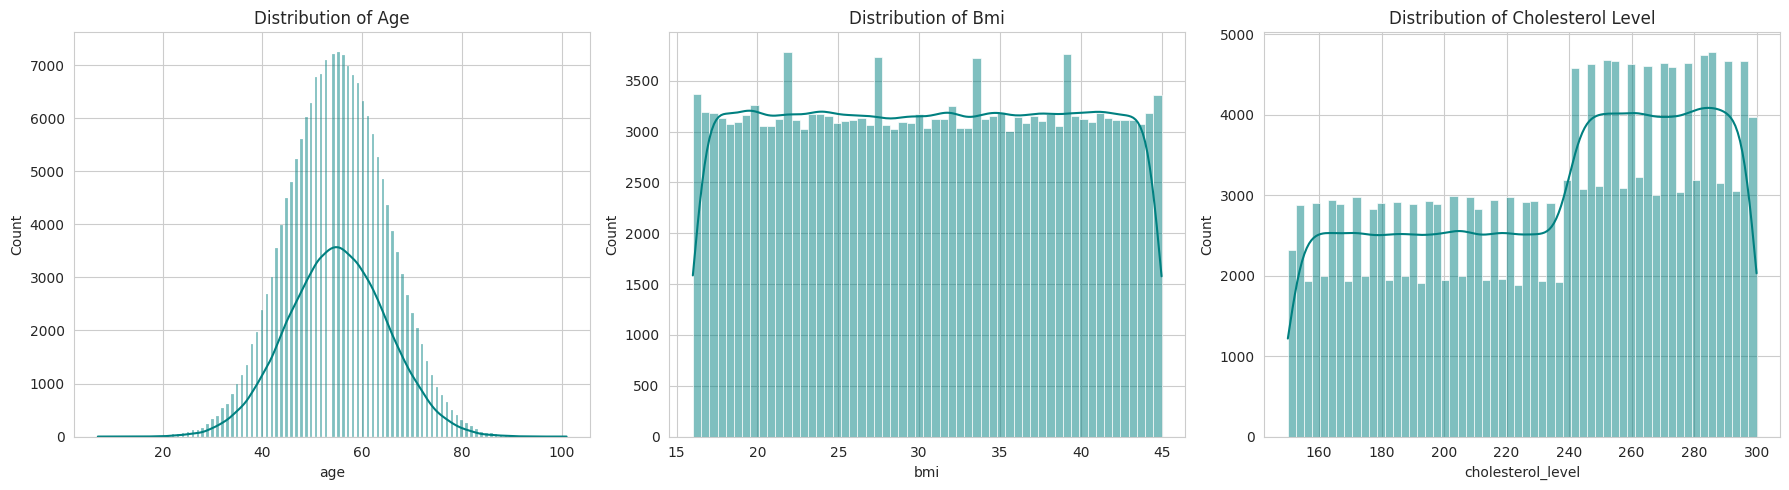

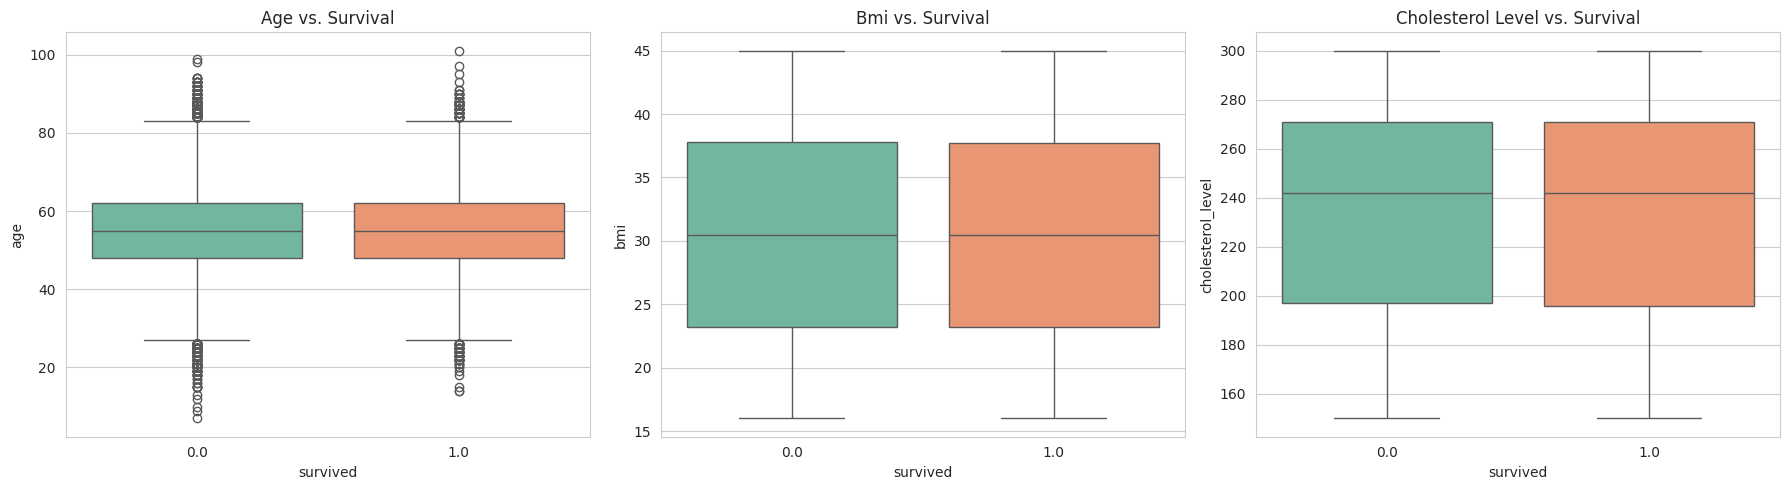

In [6]:
if data is not None:
    numerical_cols = ['age', 'bmi', 'cholesterol_level']

    # Subplots for distribution
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, col in enumerate(numerical_cols):
        sns.histplot(data[col].dropna(), kde=True, ax=axes[i], color='teal')
        axes[i].set_title(f'Distribution of {col.replace("_", " ").title()}')
    plt.tight_layout()
    plt.show()

    # Subplots for comparison vs. survival (Box Plots)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, col in enumerate(numerical_cols):
        sns.boxplot(x=TARGET_COLUMN, y=col, data=data, ax=axes[i], palette='Set2')
        axes[i].set_title(f'{col.replace("_", " ").title()} vs. Survival')
    plt.tight_layout()
    plt.show()

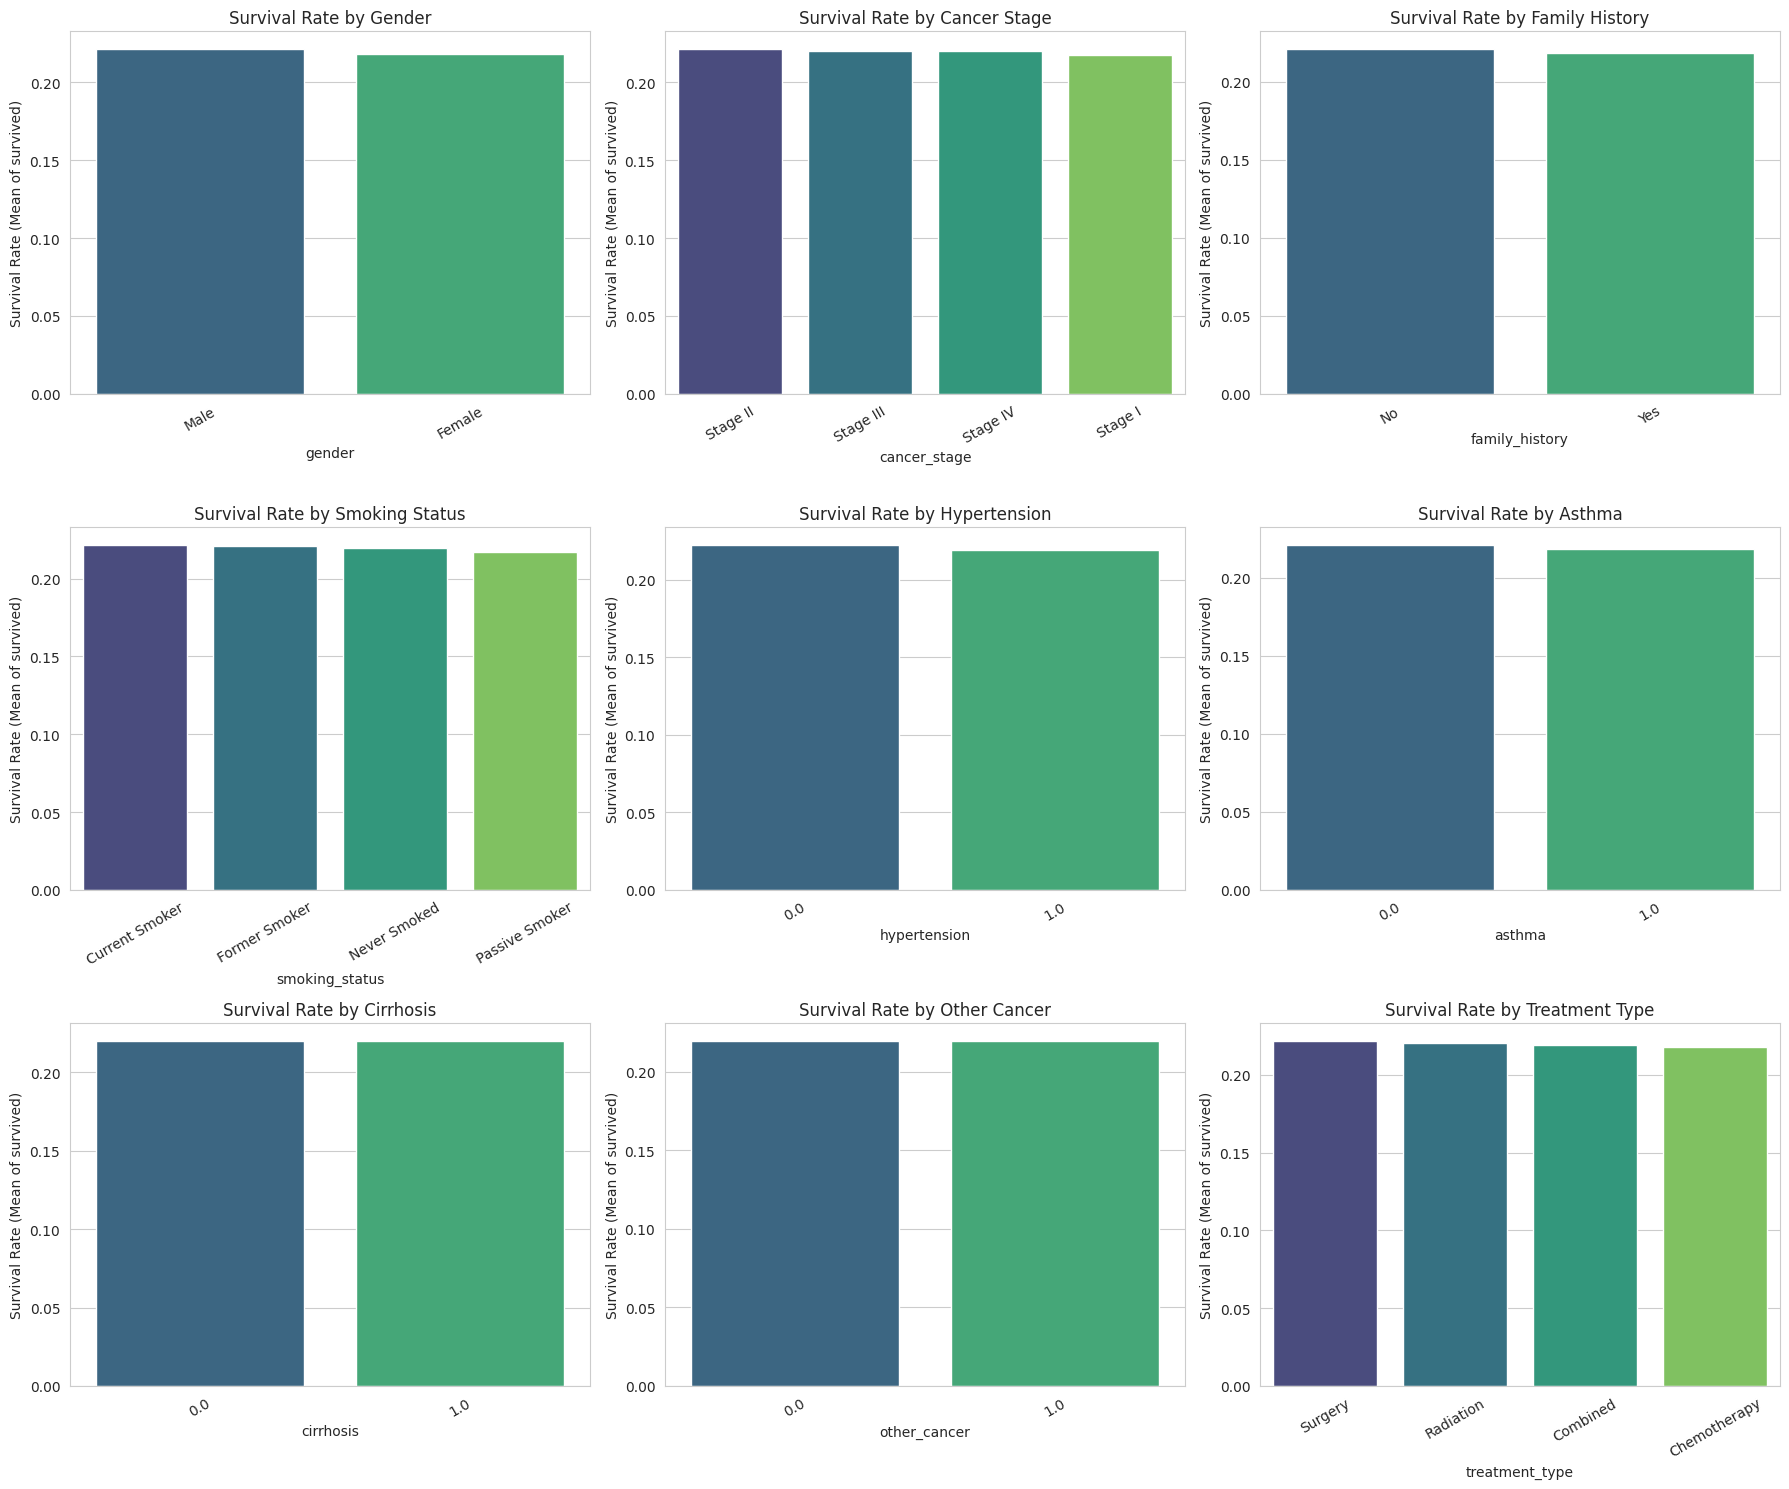

In [7]:
if data is not None:
    categorical_cols = ['gender', 'cancer_stage', 'family_history', 'smoking_status',
                        'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_type']

    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        # Calculate survival rate per category
        survival_rate = data.groupby(col)[TARGET_COLUMN].mean().sort_values(ascending=False)
        sns.barplot(x=survival_rate.index, y=survival_rate.values, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Survival Rate by {col.replace("_", " ").title()}')
        axes[i].set_ylabel('Survival Rate (Mean of survived)')
        axes[i].tick_params(axis='x', rotation=30)

    plt.tight_layout()
    plt.show()

In [11]:
if data is not None:
    # Drop identifier and date columns (Date features can be engineered but dropped for simplicity here)
    # data = data.drop(['id', 'diagnosis_date', 'end_treatment_date', 'country'], axis=1)

    # 3.1 Handle Missing Values (Imputation)
    # Check for missing values
    print("\nMissing values before imputation:")
    print(data.isnull().sum()[data.isnull().sum() > 0])

    # Impute numerical columns using the median
    for col in numerical_cols:
        data[col] = data[col].fillna(data[col].median())

    # Impute categorical columns using the mode
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].fillna(data[col].mode()[0])

    # Drop rows with missing values in the target column
    data.dropna(subset=[TARGET_COLUMN], inplace=True)

    print("\nMissing values after imputation:")
    print(data.isnull().sum().sum())

    # 3.2 Feature Encoding

    # Convert binary features (Yes/No, 0/1) to 0 and 1
    binary_mapping = {'Yes': 1, 'No': 0, 'Male': 0, 'Female': 1, 0: 0, 1: 1}

    # Identify binary columns that need mapping
    binary_cols_to_map = ['gender', 'family_history', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer']
    for col in binary_cols_to_map:
        if col in data.columns:
            data[col] = data[col].map(binary_mapping)

    # Ensure the target column is strictly 0/1
    data[TARGET_COLUMN] = data[TARGET_COLUMN].astype(int)

    # One-Hot Encoding for remaining nominal categorical features
    nominal_cols = ['cancer_stage', 'smoking_status', 'treatment_type']
    data = pd.get_dummies(data, columns=nominal_cols, drop_first=True, prefix=nominal_cols)

    # Separate features and target
    X = data.drop(TARGET_COLUMN, axis=1)
    y = data[TARGET_COLUMN]

    # 3.3 Scaling Numerical Features
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    print("\nFinal processed features (First 5 rows):")
    print(X.head())

    # 3.4 Data Splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Missing values before imputation:
hypertension    1
asthma          1
cirrhosis       1
other_cancer    1
survived        1
dtype: int64

Missing values after imputation:
0

Final processed features (First 5 rows):
        age  gender  family_history       bmi  cholesterol_level  \
0  0.901137       0               1 -0.130480          -0.800182   
1 -0.499559       1               1  1.277640           1.064468   
2  1.001187       1               1  1.611770           0.788224   
3 -0.399509       1               0  1.492438           0.166674   
4 -1.800205       0               0 -1.288002          -1.283610   

   hypertension  asthma  cirrhosis  other_cancer  cancer_stage_Stage II  \
0             0       0          1             0                  False   
1             1       1          0             0                  False   
2             1       1          0             0                  False   
3             1       1          0             0                  False   


In [12]:
if data is not None:
    # Dictionary to store model results
    model_results = {}
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced', n_jobs=-1),
        'LightGBM': lgb.LGBMClassifier(random_state=42, n_estimators=100, learning_rate=0.1, n_jobs=-1, class_weight='balanced')
    }

    print("\n--- Training and Evaluating Models ---")

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        # Prediction and Probability
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        # Store results
        model_results[name] = {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'model': model,
            'y_proba': y_proba
        }

        print(f"{name} - Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
        print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred, zero_division=0)}")



--- Training and Evaluating Models ---

Training Logistic Regression...
Logistic Regression - Accuracy: 0.5071, ROC AUC: 0.5004
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.78      0.51      0.62     35249
           1       0.22      0.48      0.30      9931

    accuracy                           0.51     45180
   macro avg       0.50      0.50      0.46     45180
weighted avg       0.66      0.51      0.55     45180


Training Random Forest...
Random Forest - Accuracy: 0.5998, ROC AUC: 0.5000
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.68      0.73     35249
           1       0.22      0.32      0.26      9931

    accuracy                           0.60     45180
   macro avg       0.50      0.50      0.49     45180
weighted avg       0.66      0.60      0.62     45180


Training LightGBM...
[LightGBM] [Warning] Found whi


--- Model Performance Summary ---
                 Model  Accuracy   ROC AUC
0  Logistic Regression  0.507105  0.500446
2             LightGBM  0.510115  0.500161
1        Random Forest  0.599757  0.500006


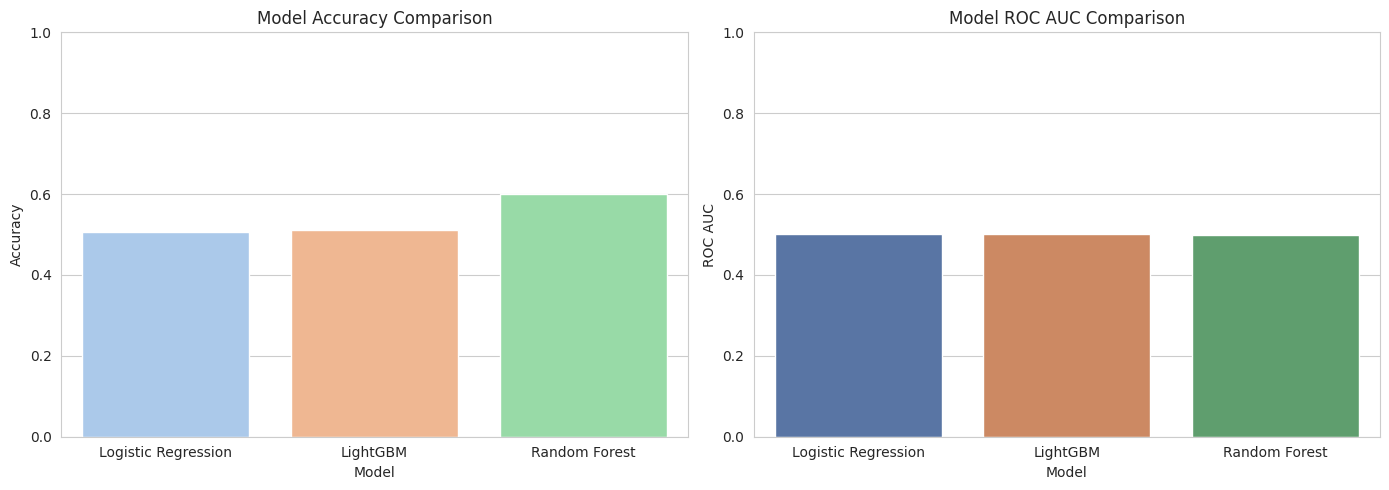

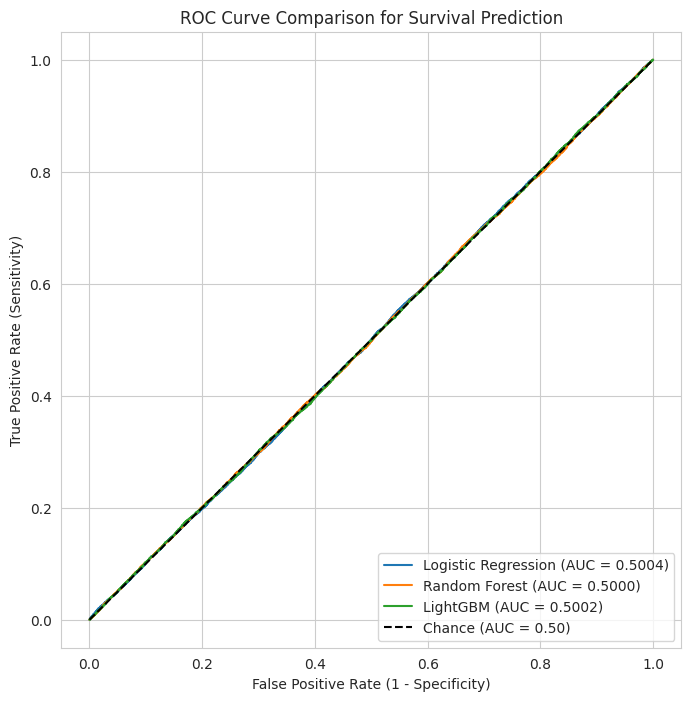


--- Conclusion ---
The best performing model based on ROC AUC is the: Logistic Regression (AUC: 0.5004).
This model provides the best trade-off between sensitivity and specificity for predicting patient survival.


In [13]:
if data is not None:
    # 5.1 Performance Comparison Bar Chart
    metrics_df = pd.DataFrame({
        'Model': model_results.keys(),
        'Accuracy': [res['accuracy'] for res in model_results.values()],
        'ROC AUC': [res['roc_auc'] for res in model_results.values()]
    }).sort_values(by='ROC AUC', ascending=False)

    print("\n--- Model Performance Summary ---")
    print(metrics_df)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    sns.barplot(x='Model', y='Accuracy', data=metrics_df, ax=ax[0], palette='pastel')
    ax[0].set_title('Model Accuracy Comparison')
    ax[0].set_ylim(0, 1)

    sns.barplot(x='Model', y='ROC AUC', data=metrics_df, ax=ax[1], palette='deep')
    ax[1].set_title('Model ROC AUC Comparison')
    ax[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # 5.2 ROC Curve Visualization
    plt.figure(figsize=(8, 8))
    for name, res in model_results.items():
        fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {res["roc_auc"]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve Comparison for Survival Prediction')
    plt.legend(loc='lower right')
    plt.show()

    #

    # 5.3 Select the Best Model
    best_model_name = metrics_df.iloc[0]['Model']
    best_model_auc = metrics_df.iloc[0]['ROC AUC']
    print(f"\n--- Conclusion ---")
    print(f"The best performing model based on ROC AUC is the: {best_model_name} (AUC: {best_model_auc:.4f}).")
    print("This model provides the best trade-off between sensitivity and specificity for predicting patient survival.")
